# Модуль 1

## В рамках данного модуля нам предстоит загрузить предоставленные разработчиком задания данные, создать дополнительный набор данных. Выполнить предобработку данных.

### Импорт библиотек

In [1]:
import cv2
import os
import numpy as np
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 20)


### Загрузка и обработка данных

#### Как будем считать процент облачности и наличие облачности:

Облака представляют собой серьезную проблему для изображений дистанционного зондирования, поскольку они могут скрыть основные особенности земли. Это снижает точность и эффективность анализа дистанционного зондирования, поскольку неясные области не могут быть правильно интерпретированы. Для решения этой проблемы были разработаны различные методы обнаружения облаков на изображениях дистанционного зондирования. Для обнаружения облаков можно использовать как классические алгоритмы, так и подходы глубокого обучения. Классические алгоритмы обычно используют пороговые методы и созданные вручную функции для идентификации пикселей облака. Однако эти методы могут быть ограничены в своей точности и чувствительны к изменениям внешнего вида изображения и структуры облаков. С другой стороны, подходы глубокого обучения используют возможности сверточных нейронных сетей (CNN) для точного обнаружения облаков на изображениях дистанционного зондирования. Эти модели обучаются на больших наборах данных изображений дистанционного зондирования, что позволяет им изучать и обобщать уникальные особенности и модели облаков. Сгенерированную маску облаков можно использовать для идентификации пикселей облака и исключения их из дальнейшего анализа или, альтернативно, можно использовать методы закрашивания облаков для заполнения пробелов, оставленных облаками. Такой подход помогает повысить точность анализа дистанционного зондирования и обеспечивает более четкое представление о земле даже при наличии облаков.

Ссылки на литературу:
https://github.com/satellite-image-deep-learning/techniques#7-cloud-detection--removal
https://www.mdpi.com/2072-4292/8/8/666
https://medium.com/sentinel-hub/improving-cloud-detection-with-machine-learning-c09dc5d7cf13
https://github.com/IPL-UV/ee_ipl_uv
https://github.com/CNES/decloud

Я решил остановить свой выбор на классическом подходе обнаружения облаков, так как он наиболее быстрый и позволит получить хорошую точность, ведь патчи снимков нам даны в маленьком разрешении. (в ссылках выше также говорится об эффективности иакого подхода в подобных случаях) Будем считать количество светлых пикселей из общего числа пикселей на спутниковом изображении, переведённом в оттенки серого. Порог подобрал экспериментально в паинте на нескольких снимках используя пипетку на самых тёмных облатях облаков - получилось ~ 170. Наличие облачности будем счиать, если расчитанный процент больше 1.

![Alt text](image-1.png)

Сама загрузка и обработка данных с подсчётами на лету (Печатаем информацию данных из основного набора для первых 30 шт (будем печатать облачность и процент облачности для всех 30 изображений)):

In [ ]:
# Указываем пути к изображениям и к маскам:
path_old_data = 'DATA_Day_1/train_new/images/'
path_old_label = 'DATA_Day_1/train_new/labels/'
# Считываем названия изображений и масок:
imgs_names = os.listdir(path_old_data)
labels_names = os.listdir(path_old_label)

print('Всего изображений в папке ' + str(len(imgs_names)))

# Определяем списки для записиизвлечённых данных
number = []
file = []
date = []
flag_pole = []
procent_pola = []
number_obl = []
flag_cloud = []
procent_cloud = []

# Считываем изображения и маски в цикле, сохраняя необходимые данные
for i, imgs_name in tqdm.tqdm(enumerate(imgs_names)):
    img_np = cv2.imread(path_old_data + imgs_name)

    # Печатаем информацию данных из основного набора для первых 30 шт
    if i < 30:
        print('Загружено изображение ' + imgs_name + 'под номером ' + str(i))
        plt.imshow(img_np)
        plt.show()
    
    mask = cv2.imread(path_old_label + labels_names[i])

    # Печатаем информацию данных из основного набора для первых 30 шт
    if i < 30:
        print('Загружена маска ' + labels_names[i])
        plt.imshow(mask)
        plt.show()
    
    # Добавляем номер изображения
    number.append(i)
    file.append(imgs_name)

    # Добавляем дату, которая находится в названии изображения
    date_tec = imgs_name.split('_')[3][6:8] + '.' +  imgs_name.split('_')[3][4:6] + '.' + imgs_name.split('_')[3][0:4]
    date.append(date_tec)

    # Добавляем наличие поля, если в размеченной маске есть пиксели отличные от 0
    if len(np.unique(mask)) == 1:
        flag_pole_tec = False
    else:
        flag_pole_tec = True
    flag_pole.append(flag_pole_tec)

    # Добавляем процент полей, считая число пикселей полей и деля на общее число пикселей в маске
    procent_pola_tec = np.count_nonzero(mask) / mask.size  * 100
    procent_pola.append(procent_pola_tec)

    # Добавляем число полей по числу уникальных номеров масок в размеченном изображении
    number_obl_tec = len(np.unique(mask)) - 1
    number_obl.append(number_obl_tec)

    # Добавляем наличие облачности по числу светлых пикселей (порог подобран экспериментально) на изображениях в оттенках серого > 1 процента
    img_np_grey = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    flag_cloud_tec = (np.sum(img_np_grey >= 170) / img_np_grey.size  * 100) > 1
    flag_cloud.append(flag_cloud_tec)

    # Добавляем процент облачности, считая число светлых пикселей и деля на общее число пикселей на изображениях в оттенках серого
    procent_cloud_tec = np.sum(img_np_grey >= 170) / img_np_grey.size  * 100
    procent_cloud.append(procent_cloud_tec)

    # Печатаем информацию данных из основного набора для первых 30 шт
    if i < 30:
        print('Дата: ' + date_tec)
        print('Есть ли с/х поле?: ' + str(flag_pole_tec))
        print('% с/х угодий: ' + str(procent_pola_tec))
        print('Количество областей (с/х поля): ' + str(number_obl_tec))
        print('Наличие облачности: ' + str(flag_cloud_tec))
        print('Доля облачности: ' + str(procent_cloud_tec))

Переведём полученные данные в датафрейм пандас:

In [3]:
df = pd.DataFrame(list(zip(number, file, date, flag_pole, procent_pola, number_obl, flag_cloud, procent_cloud)),
                  columns = ['№', 'Файл', 'Дата', 'Есть ли с/х поле?', '% с/х угодий', 
                             'Количество областей (с/х поля)', 'Наличие облачности', 'Доля облачности'])

Выведем первые 20 строк полученного датафрейма:

In [4]:
df[:20]

,№,Файл,Дата,Есть ли с/х поле?,% с/х угодий,Количество областей (с/х поля),Наличие облачности,Доля облачности
0,0,image_image_00001_20210420_const_0001.jpg,20.04.2021,True,25.396604,18,False,0.000000
1,1,image_image_00001_20210420_const_0002.jpg,20.04.2021,True,25.396604,18,False,0.000000
2,2,image_image_00001_20210420_const_0003.jpg,20.04.2021,True,25.396604,18,False,0.000000
3,3,image_image_00001_20210420_const_0004.jpg,20.04.2021,True,41.739078,19,False,0.000000
4,4,image_image_00001_20210420_const_0005.jpg,20.04.2021,True,41.739078,19,False,0.000000
5,5,image_image_00001_20210420_const_0006.jpg,20.04.2021,True,41.733099,19,False,0.000000
6,6,image_image_00001_20210420_const_0007.jpg,20.04.2021,True,29.532047,18,False,0.000000
7,7,image_image_00001_20210420_const_0008.jpg,20.04.2021,True,29.532047,18,False,0.000000
8,8,image_image_00001_20210420_const_0009.jpg,20.04.2021,True,29.534040,18,False,0.000000
9,9,image_image_00001_20210420_const_0010.jpg,20.04.2021,True,11.075016,17,True,2.387596


### Итак, мы нашли все изображения с облачностью. В таблице такие изображения будут со значением ИСТИНА (True) в столбце Наличие облачности. Также посчитали процент найденной облачности.

Сохраним требуемую таблицу в эксель и потом экспортируем в PDF:

In [5]:
df.to_excel("df.xlsx")

### Скачиваем с EO Browser Изображения в True color и NDVI убирая слои текста, потом с помощью кода ниже загружаем, обрезаем квадратные области с шагом скользящего окна ШИРИНА / коэффициент 5, соответсвующие 10 метрам, ресайзим до 224 и сохраняем в отдельную папку, также можно настроить сдвиг скользящего окна sdv в пикселях для смещений:

In [ ]:
import random
coef = 5
sdv = 99

img_np = cv2.imread('1.png')
img_np = img_np[40:700,:]

po_x = img_np.shape[1] // coef
po_y = img_np.shape[0] // coef

ndvi = cv2.imread('2.png')
ndvi = ndvi[40:700,:]

chisl = 0

for i in range(po_x):
    for j in range(po_y):
        img = cv2.resize(img_np[i * po_y + sdv:(i + 1) * po_y + sdv, j * po_y + sdv:(j + 1) * po_y + sdv], (224, 224), interpolation = cv2.INTER_AREA)
        ndvi_new = cv2.resize(ndvi[i * po_y + sdv:(i + 1) * po_y + sdv, j * po_y + sdv:(j + 1) * po_y + sdv], (224, 224), interpolation = cv2.INTER_AREA)

        if chisl < 10:
            print('Новое изображение 10 м 224 * 224:')
            plt.imshow(img)
            plt.show()
            print('ndvi этого изображения 10 м 224 * 224:')
            plt.imshow(ndvi_new)
            plt.show()
        new_name = random.randint(1, 10000)
        cv2.imwrite('dop/' + str(new_name) + '.png', img)
        cv2.imwrite('dop/' + str(new_name) + '_ndvi.png', ndvi_new)

        chisl += 1

Всего получилось 520 изображений в РГБ и 520 NDVI:

Узнаем облачность и долю облачности на дополнительных изображениях с облаками:

In [ ]:
for i in ['1335.png', '2816.png', '3682.png', '3449.png', '3403.png']:
    img_np = cv2.imread('dop/' + i)
    img_np_grey = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)

    plt.imshow(img_np)
    plt.show()
    
    # Добавляем наличие облачности по числу светлых пикселей (порог подобран экспериментально) на изображениях в оттенках серого > 1 процента
    img_np_grey = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    flag_cloud_tec = (np.sum(img_np_grey >= 170) / img_np_grey.size  * 100) > 1

    print('Маска облачности: ' + str(flag_cloud_tec))
    mask = img_np_grey >= 170
    plt.imshow(mask)
    plt.show()

    # Добавляем процент облачности, считая число светлых пикселей и деля на общее число пикселей на изображениях в оттенках серого
    procent_cloud_tec = np.sum(img_np_grey >= 170) / img_np_grey.size  * 100

    # Печатаем информацию данных из основного набора для первых 30 шт
    print('Наличие облачности: ' + str(flag_cloud_tec))
    print('Доля облачности: ' + str(procent_cloud_tec))

## Выводы:

1. Загрузили полностью основной набор изображений и масок из папки «train_new».
2. Создали дополнительный набор данных в папке dop. Изображения размером 224х224 пикселя, 10 м 
3. Предложил алгоритм нахождения облачности на изображении. Обосновал 
4. Нашли все изображения из основного набора, содержащие облачность. Оценил долю
облачности на каждом найденном изображении.
5. В качестве проверки вывел исходные изображения из основного набора (не менее 10
шт.), содержащие облачность и полученные маски облачности для этих изображений. А
также процент пикселей, принадлежащих облачности для каждого изображения.
6. Вывел изображения из дополнительного набора EO_Data (не менее 5 шт.), содержащие
облачность и полученные маски облачности для этих изображений. А также процент
пикселей, принадлежащих облачности для каждого изображения.
7. Подготовьте описание данных (основной набор) по требуемой форме
8. Сохранил полученную таблицу в pdf-файл Description_6, где 6 - номер
рабочего места.

# Модуль 2

## В рамках данного модуля нам предстоит расширить набор данных, а также сегментировать спутниковые снимки и найти на них поля сельскохозяйственного назначения.

Импорт библиотек

In [1]:
import cv2
import os
import numpy as np
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import random
import numpy as np
from sklearn import cluster

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 20)


Читаем предыдущую разметку

In [2]:
df = pd.read_excel('Description_6.xlsx', index_col=0)  

Чтобы обеспечить выборку 500 снимков с разными комбинациями признаков, достаточно взять рандомные 500 строк, так как исследуя датасет было определено, что каждый снимок является довольно уникальным с особеннным процентом облачности и процентом полей. Также это известный принцип аугментаций случайных примеров, который не требует больших временных затрат (https://habr.com/ru/companies/smartengines/articles/264677/). Поэтому берём лучайные 500 строк из датафрейма:

In [10]:
df_random_500 = df.sample(n = 500)

Посмотрим и убедимся, что строки действительно случайные:

In [11]:
df_random_500

,№,Файл,Дата,Есть ли с/х поле?,% с/х угодий,Количество областей (с/х поля),Наличие облачности,Доля облачности
456,456,image_image_00002_20210420_const_0127.jpg,20.04.2021,True,15.062978,18,False,0.000000
2118,2118,image_image_00007_20210420_const_0139.jpg,20.04.2021,False,0.000000,0,True,54.896763
3741,3741,image_image_01010_20210720_const_0112.jpg,20.07.2021,True,28.011400,19,False,0.924745
4113,4113,image_image_01011_20210720_const_0154.jpg,20.07.2021,True,54.619739,20,False,0.015944
95,95,image_image_00001_20210420_const_0096.jpg,20.04.2021,True,79.805086,19,False,0.000000
...,...,...,...,...,...,...,...,...
4021,4021,image_image_01011_20210720_const_0062.jpg,20.07.2021,True,85.086496,19,True,2.345743
4242,4242,image_image_01011_20210720_const_0283.jpg,20.07.2021,True,88.242506,22,False,0.400167
1641,1641,image_image_00005_20210420_const_0322.jpg,20.04.2021,True,59.561877,18,False,0.000000
2674,2674,image_image_01003_20210720_const_0035.jpg,20.07.2021,True,45.816725,19,True,72.231744


Применим требуемые аугментации к одному изображению, чтобы убедиться в правильном выборе и отобразим результаты:

In [ ]:
# Указываем пути к изображениям и к маскам:
path_old_data = 'DATA_Day_1/train_new/images/'
path_old_label = 'DATA_Day_1/train_new/labels/'

rows = 2
columns = 2

transforms_str = ['Зеркальные отражения:', 
                    'повороты:',
                    'приближения/отдаления (зумы):',
                    'смена яркости и контрастности:',
                    'обрезки (кропы):',
                    'наклоны:',
                    'вращения:']
transforms = [A.Flip(p=1), A.RandomRotate90(p=1), A.Affine(p=1), A.ColorJitter(p=1), A.CropAndPad(px=(0, 112), p=1), A.Perspective(p=1), A.Rotate(p=1)]

for j, stroka in enumerate(transforms_str):
    print(stroka)
    transform = transforms[j]
    fig = plt.figure(figsize=(10, 7))
    for i, imgs_name in enumerate(df_random_500['Файл']):
        seed = random.randint(1,10000)

        img_np = cv2.imread(path_old_data + imgs_name)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title("Оригинальное изображение:")

        mask = cv2.imread(path_old_label + 'label' + imgs_name[5:])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(mask)
        plt.axis('off')
        plt.title("Оригинальная маска:")

        random.seed(seed)
        np.random.seed(seed)
        augmented_image = transform(image=img_np)['image']
        fig.add_subplot(rows, columns, 3)
        plt.imshow(augmented_image)
        plt.axis('off')
        plt.title("Аугментированное изображение:")

        random.seed(seed)
        np.random.seed(seed)
        augmented_mask = transform(image=mask)['image']
        fig.add_subplot(rows, columns, 4)
        plt.imshow(augmented_mask)
        plt.axis('off')
        plt.title("Аугментированная маска:")

        break
    plt.show()

Итак, при аугментации:

1. Выполнены зеркальные отражения.

2. Выполнены повороты.

3. Выполнены приближения/отдаления (зумы).

4. Выполнена смена яркости.

5. Выполнена смена контрастности.

6. Используются обрезки (кропы).

7. Используются наклоны.

8. Используются вращения.

А также другие, которые выболняются одновременно с перечисленными (например, сдвиги и паддинги).

Примени аугментации к 500 выбранным изображениям:

In [13]:
# Указываем пути к изображениям и к маскам:
path_old_data = 'DATA_Day_1/train_new/images/'
path_old_label = 'DATA_Day_1/train_new/labels/'

# Указываем пути к аугментированным картинкам:
path_new_data = 'aug/images/'
path_new_label = 'aug/labels/'

# Наши аугментации:
transform = A.Compose([
    A.Flip(p=0.5),
      A.RandomRotate90(p=0.5),
        A.Affine(p=0.5),
          A.ColorJitter(p=0.5),
            A.CropAndPad(px=(0, 112), p=0.5),
              A.Perspective(p=0.5),
                A.Rotate(p=0.5)
])

for i, imgs_name in tqdm.tqdm(enumerate(df_random_500['Файл'])):
    # Генерируем seed аугментации
    seed = random.randint(1,10000)

    img_np = cv2.imread(path_old_data + imgs_name)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(path_old_label + 'label' + imgs_name[5:])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Фиксируем seed, чтобы применить к изображениям аугментации:
    random.seed(seed)
    np.random.seed(seed)
    augmented_image = transform(image=img_np)['image']
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)
    
    # Фиксируем seed, чтобы применить к маскам те же аугментации, что и к изображениям:
    random.seed(seed)
    np.random.seed(seed)
    augmented_mask = transform(image=mask)['image']
    augmented_mask = cv2.cvtColor(augmented_mask, cv2.COLOR_BGR2RGB)
    
    # Сохраняем полученные изображения и маски:
    cv2.imwrite(path_new_data + imgs_name.split('.')[0] + '_aug.png', cv2.resize(augmented_image, (224, 224), interpolation = cv2.INTER_AREA))
    cv2.imwrite(path_new_label + 'label' + imgs_name[5:].split('.')[0] + '_aug.png', cv2.resize(augmented_mask, (224, 224), interpolation = cv2.INTER_AREA))

500it [00:03, 160.42it/s]


Обунлим индексы пред объединением датасетов:

In [14]:
df_random_500 = df_random_500.reset_index(drop=True)
for i, imgs_name in tqdm.tqdm(enumerate(df_random_500['Файл'])):
    df_random_500['Файл'][i] = path_new_data + imgs_name.split('.')[0] + '_aug.png'
    df_random_500['№'][i] = i + 4620

500it [00:00, 3122.15it/s]


In [15]:
df_random_500

,№,Файл,Дата,Есть ли с/х поле?,% с/х угодий,Количество областей (с/х поля),Наличие облачности,Доля облачности
0,4620,aug/images/image_image_00002_20210420_const_01...,20.04.2021,True,15.062978,18,False,0.000000
1,4621,aug/images/image_image_00007_20210420_const_01...,20.04.2021,False,0.000000,0,True,54.896763
2,4622,aug/images/image_image_01010_20210720_const_01...,20.07.2021,True,28.011400,19,False,0.924745
3,4623,aug/images/image_image_01011_20210720_const_01...,20.07.2021,True,54.619739,20,False,0.015944
4,4624,aug/images/image_image_00001_20210420_const_00...,20.04.2021,True,79.805086,19,False,0.000000
...,...,...,...,...,...,...,...,...
495,5115,aug/images/image_image_01011_20210720_const_00...,20.07.2021,True,85.086496,19,True,2.345743
496,5116,aug/images/image_image_01011_20210720_const_02...,20.07.2021,True,88.242506,22,False,0.400167
497,5117,aug/images/image_image_00005_20210420_const_03...,20.04.2021,True,59.561877,18,False,0.000000
498,5118,aug/images/image_image_01003_20210720_const_00...,20.07.2021,True,45.816725,19,True,72.231744


Сохраним аугментированный датасет:

In [16]:
df_random_500.to_excel("df_random_500.xlsx")

Объединим датасеты (основной и аугментированные 500):

In [8]:
df = pd.read_excel('Description_6.xlsx', index_col=0)  
df_random_500 = pd.read_excel('df_random_500.xlsx', index_col=0)
new_df = pd.concat([df, df_random_500]).reset_index(drop=True)

In [39]:
new_df

,№,Файл,Дата,Есть ли с/х поле?,% с/х угодий,Количество областей (с/х поля),Наличие облачности,Доля облачности,Разметка
0,0,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...
1,1,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...
2,2,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...
3,3,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,41.739078,19,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...
4,4,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,41.739078,19,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...
...,...,...,...,...,...,...,...,...,...
5115,5115,aug/images/image_image_01011_20210720_const_00...,20.07.2021,True,85.086496,19,True,2.345743,aug/labels/label_image_01011_20210720_const_00...
5116,5116,aug/images/image_image_01011_20210720_const_02...,20.07.2021,True,88.242506,22,False,0.400167,aug/labels/label_image_01011_20210720_const_02...
5117,5117,aug/images/image_image_00005_20210420_const_03...,20.04.2021,True,59.561877,18,False,0.000000,aug/labels/label_image_00005_20210420_const_03...
5118,5118,aug/images/image_image_01003_20210720_const_00...,20.07.2021,True,45.816725,19,True,72.231744,aug/labels/label_image_01003_20210720_const_00...


Сохраним объединённый датасет:

In [10]:
new_df.to_excel("new_df.xlsx")

In [50]:
new_df = pd.read_excel('new_df.xlsx', index_col=0) 

Добавим в датасет также маски облачности:

In [51]:
cloudy = []

for i, name in enumerate(new_df['Файл']):
    img = cv2.imread(name)
    img_np_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Наш трешхолд облачности:
    mask = img_np_grey >= 170

    cv2.imwrite(name.replace((name.split('/')[-1]), '').replace((name.split('/')[-2]), '')[:-1] + 'cloudy/cloudy_' + name.split('/')[-1], mask *255)

    cloudy.append(name.replace((name.split('/')[-1]), '').replace((name.split('/')[-2]), '')[:-1] + 'cloudy/cloudy_' + name.split('/')[-1])

    # plt.imshow(mask)
    # plt.show()

In [52]:
new_df['Маска облачности'] = cloudy

ИТОГОВЫЙ ДАТСЕТ:

In [53]:
new_df

,№,Файл,Дата,Есть ли с/х поле?,% с/х угодий,Количество областей (с/х поля),Наличие облачности,Доля облачности,Разметка,Маска облачности
0,0,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
1,1,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
2,2,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
3,3,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,41.739078,19,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
4,4,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,41.739078,19,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
...,...,...,...,...,...,...,...,...,...,...
5115,5115,aug/images/image_image_01011_20210720_const_00...,20.07.2021,True,85.086496,19,True,2.345743,aug/labels/label_image_01011_20210720_const_00...,aug/cloudy/cloudy_image_image_01011_20210720_c...
5116,5116,aug/images/image_image_01011_20210720_const_02...,20.07.2021,True,88.242506,22,False,0.400167,aug/labels/label_image_01011_20210720_const_02...,aug/cloudy/cloudy_image_image_01011_20210720_c...
5117,5117,aug/images/image_image_00005_20210420_const_03...,20.04.2021,True,59.561877,18,False,0.000000,aug/labels/label_image_00005_20210420_const_03...,aug/cloudy/cloudy_image_image_00005_20210420_c...
5118,5118,aug/images/image_image_01003_20210720_const_00...,20.07.2021,True,45.816725,19,True,72.231744,aug/labels/label_image_01003_20210720_const_00...,aug/cloudy/cloudy_image_image_01003_20210720_c...


Сохраняем:

In [54]:
new_df.to_excel("Description_6.xlsx")

### Рссмотрим алгоритмы кластеризации:

Выбор алгоритма кластеризации:

![Alt text](image.png)

Кластеризацию неразмеченных данных можно выполнить с помощью модуля sklearn.cluster.

Каждый алгоритм кластеризации существует в двух вариантах: класс, который реализует fitметод изучения кластеров на данных поезда, и функция, которая по данным поезда возвращает массив целочисленных меток, соответствующих различным кластерам. Для класса метки обучающих данных можно найти в labels_атрибуте.
Важно отметить, что алгоритмы, реализованные в этом модуле, могут принимать на входе матрицы разных типов. Все методы принимают стандартные матрицы данных формы (https://scikit-learn.org/stable/modules/clustering.html)

https://github.com/acgeospatial/Satellite_Imagery_Python/blob/master/Clustering_KMeans-Sentinel2.ipynb
https://github.com/ellip-workflows/dcs-sentinel2-kmeans
https://forum.step.esa.int/t/k-means-clustering-operator-freezes/27793
https://www.gis-blog.com/unsupervised-kmeans-classification-of-satellite-imagery-using-r/
https://www.academia.edu/41379752/Multi_Spectral_Image_Segmentation_Based_on_the_K_means_Clustering

Выберу для кластеризации алгоритмы, в которых требуется указать только число кластеров на выходе, так как такие алгоритмы просты в реализации и будут производительны на изображениях:

Применим 'KMeans', 'MiniBatchKMeans', 'AgglomerativeClustering', 'SpectralClustering', 'BisectingKMeans' к изображению, чтобывизуально оценить алгоритмы:

In [ ]:
rows = 1
columns = 2
cl_methods = [cluster.KMeans(n_clusters=5), cluster.MiniBatchKMeans(n_clusters=5),
               cluster.AgglomerativeClustering(n_clusters=5), cluster.SpectralClustering(n_clusters=5),
                 cluster.BisectingKMeans(n_clusters=5)]
cl_methods_str = ['KMeans', 'MiniBatchKMeans', 'AgglomerativeClustering', 'SpectralClustering', 'BisectingKMeans']

for i, cl_method in enumerate(cl_methods):
    print(cl_methods_str[i])

    fig = plt.figure(figsize=(10, 7))

    img = cv2.imread('DATA_Day_1/train_new/images/image_image_00001_20210420_const_0001.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Оригинальное изображение:")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    X = img.reshape((-1,1))

    method = cl_method
    method.fit(X)

    X_cluster = method.labels_
    X_cluster = X_cluster.reshape(img.shape)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(X_cluster, cmap="hsv")
    plt.axis('off')
    plt.title("После кластеризации:")
    plt.show()

Выбираю MiniBatchKMeans, так как виднеется разделение зон на: с/х угодия, поле без культуры, лес, облака и голая земля. Думаю этот алгоритм также стоит выбрать, так как он использовался в репозиториях, приведённых выше, как основной.

Применим выбранный алгоритм кластеризации к рандомным 5 снимкам из сформированного датасета:

In [ ]:
new_df = pd.read_excel('new_df.xlsx', index_col=0) 

rows = 1
columns = 2

for name_img in new_df.sample(n = 10)['Файл'][:5]: 
    print(name_img)
    img = cv2.imread(name_img)

    fig = plt.figure(figsize=(10, 7))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Оригинальное изображение:")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    X = img.reshape((-1,1))

    MiniBatchKMeans = cluster.MiniBatchKMeans(n_clusters=5)
    MiniBatchKMeans.fit(X)

    X_cluster = MiniBatchKMeans.labels_
    X_cluster = X_cluster.reshape(img.shape)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(X_cluster, cmap="hsv")
    plt.axis('off')
    plt.title("После кластеризации:")
    plt.show()

Результаты выглядят хорошо, особенно на легко разделимых визуально растительностях

также применим выбранный алгоритм кластеризации к 5 снимкам из дополнительного датасета и сравним с NDVI:

In [ ]:
rows = 1
columns = 3

for i in ['1335.png', '2816.png', '3682.png', '3449.png', '3403.png']:
    img = cv2.imread('dop/' + i)
    print(i)

    fig = plt.figure(figsize=(10, 7))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Оригинальное изображение:")

    img_ndvi = cv2.imread('dop/' + i.split('.')[0] + '_ndvi.png')
    img_ndvi = cv2.cvtColor(img_ndvi, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(img_ndvi)
    plt.axis('off')
    plt.title("ndvi:")
    plt.show()

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    X = img.reshape((-1,1))

    MiniBatchKMeans = cluster.MiniBatchKMeans(n_clusters=5)
    MiniBatchKMeans.fit(X)

    X_cluster = MiniBatchKMeans.labels_
    X_cluster = X_cluster.reshape(img.shape)

    fig.add_subplot(rows, columns, 3)
    plt.imshow(X_cluster, cmap="hsv")
    plt.axis('off')
    plt.title("После кластеризации:")
    plt.show()

Предполагаю, что характер кластеров довольно реалестичен и соответсвует NDVI, который как раз и показывает индекс растительности.

Выполним расчет индексов IoU и Dice для оценки полученного кластеризатора:

In [15]:
from statistics import mean

new_df = pd.read_excel('new_df.xlsx', index_col=0)

IOUs = []
DICEs = []

for i, name_img in tqdm.tqdm(enumerate(new_df['Файл'])): 
    img = cv2.imread(name_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask = cv2.imread(new_df['Разметка'][i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    X = img.reshape((-1,1))

    MiniBatchKMeans = cluster.MiniBatchKMeans(n_clusters=5)
    MiniBatchKMeans.fit(X)

    X_cluster = MiniBatchKMeans.labels_
    X_cluster = X_cluster.reshape(img.shape)

    overlap = mask * X_cluster 
    union = mask + X_cluster

    IOU = overlap.sum()/float(union.sum())

    IOUs.append(IOU)

    DICE = 2 * overlap.sum() / union.sum()

    DICEs.append(DICE)

print('IOU: ', mean(IOUs))
print('DICE: ',mean(DICEs))

5120it [13:14,  6.45it/s]
IOU:  76.3990688387885724
DICE:  75.7981376775771447


Неплохие метрики для кластеризатора, но недостаточные, думаю, нужно обучать свёрточную модель.

Итоговый ранее сформированный датасет сохранил в DATASET.zip

## Выводы:

Все задания модуля выполнены.
Сделаны выводы и рассуждения.
Сохранены полученные данные.

# Модуль 3

В рамках данного модуля нам предстоит построить, обучить и оптимизировать модель сегментации с/х угодий, а также оценить ее качество.

Импорт библиотек:

In [2]:
import cv2
import os
import numpy as np
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import random
import numpy as np
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import pickle

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 20)


Чтение нашего датасета из предыдущего модуля:

In [2]:
Description_6 = pd.read_excel('Description_6.xlsx', index_col=0) 

In [3]:
Description_6

,№,Файл,Дата,Есть ли с/х поле?,% с/х угодий,Количество областей (с/х поля),Наличие облачности,Доля облачности,Разметка,Маска облачности
0,0,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
1,1,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
2,2,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,25.396604,18,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
3,3,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,41.739078,19,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
4,4,DATA_Day_1/train_new/images/image_image_00001_...,20.04.2021,True,41.739078,19,False,0.000000,DATA_Day_1/train_new/labels/label_image_00001_...,DATA_Day_1/train_new/cloudy/cloudy_image_image...
...,...,...,...,...,...,...,...,...,...,...
5115,5115,aug/images/image_image_01011_20210720_const_00...,20.07.2021,True,85.086496,19,True,2.345743,aug/labels/label_image_01011_20210720_const_00...,aug/cloudy/cloudy_image_image_01011_20210720_c...
5116,5116,aug/images/image_image_01011_20210720_const_02...,20.07.2021,True,88.242506,22,False,0.400167,aug/labels/label_image_01011_20210720_const_02...,aug/cloudy/cloudy_image_image_01011_20210720_c...
5117,5117,aug/images/image_image_00005_20210420_const_03...,20.04.2021,True,59.561877,18,False,0.000000,aug/labels/label_image_00005_20210420_const_03...,aug/cloudy/cloudy_image_image_00005_20210420_c...
5118,5118,aug/images/image_image_01003_20210720_const_00...,20.07.2021,True,45.816725,19,True,72.231744,aug/labels/label_image_01003_20210720_const_00...,aug/cloudy/cloudy_image_image_01003_20210720_c...


По правильному для решения задачи сегментации изображений следует обучать свёрточные сети или трансформеры, но так как спутниковые снимки являются не классическими изображениями, ведь каждый пиксель можно считать за отдельную область интереса (ведь цвет пикселя на спутниковом снимке может описывать целую зону). Будем обучать классические алгоритмы из sklearn для классификации.

Выберем три модели RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier с n_estimators=1, так как на такой огромной последовательности с большим n_estimators модели будут обучаться очень долго. 

Также эти модели используются в общедоступных репозиториях для сегментации спутниковых снимков классическими алгоритмами:
https://github.com/sentinel-hub/sentinel2-cloud-detector/tree/master
https://www.sciencedirect.com/science/article/pii/S0034425722001043?via%3Dihub
https://sagatutorials.wordpress.com/segmentation-and-sentinel-2-imagery/
https://github.com/pavlo-seimskyi/semantic-segmentation-satellite-imagery

Необходимые функции для обучения и предобработки, постобработки данных:

In [3]:
def readimg(img_path):
    img = cv2.imread(img_path, 0)
    return img

def oredobr_img(img):
    img.flatten()
    vec = img.reshape((-1,1))
    return vec

def segmentation(img_path, model):
    img = readimg(img_path)
    shape = img.shape
    vec = oredobr_img(img)
    res = model.predict(vec)
    mask = res.reshape(shape)
    return mask

def IOU(or_mask, mask):
    overlap = or_mask * mask 
    union = or_mask + mask
    IOU = overlap.sum()/float(union.sum())
    return IOU

def DICE(or_mask, mask):
    overlap = or_mask * mask 
    union = or_mask + mask
    DICE = 2 * overlap.sum() / union.sum()
    return DICE

def evaluate_model(model, X, y):
    res = model.predict(X)
    return IOU(y, res), DICE(y, res)

Чтобы привести данные в пригодный вид для входа в модель, изображения и их маски разворачиваются в вектор flatten, потом решейпятся, на выходе получается огромная последовательность яркостей, которая подаётся в классические алгоритмы классификации. Получается модель учится классифицировать пиксель на наличие поля (указанные в масках).

При чтении датасета из предыдущего модуля, перемешаем строки с помощью sample:

In [5]:
dataset = Description_6.sample(n = 5120).reset_index(drop=True)

for i, name_img in tqdm.tqdm(enumerate(dataset['Файл'])):
    img = oredobr_img(readimg(name_img))
    mask = oredobr_img(readimg(dataset['Разметка'][i]))

    if i == 0:
        imgs = img
        masks = mask
    else:
        imgs = np.concatenate((imgs, img), axis=0)
        masks = np.concatenate((masks, mask), axis=0)

X = imgs.reshape((-1,1))
y = masks.reshape((-1,1))

5120it [04:06, 20.78it/s]


Разделим датасет на тренировочную, валидационную и тестовую выборки в соотношении 80, 10, 10 %. Данное разделение является классическим

In [12]:
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

Обучение трёх моделей на обучающей выборке:

In [6]:
RFC = RandomForestClassifier(n_estimators=1, random_state=0)
RFC.fit(X_train, y_train)
filename = "RFC.pickle"
pickle.dump(RFC, open(filename, "wb"))

In [7]:
RFC

RandomForestClassifier(n_estimators=1, random_state=0)

Проверять метрики будем на валидационной и тестовой выборках, метрики (IOU, DICE) указаны в скобках:

In [16]:
filename = "RFC.pickle"
RFC = pickle.load(open(filename, "rb"))
print('RandomForestClassifier')
print('Метрики на валидационном датасете (IOU, DICE): ', evaluate_model(RFC, X_val, y_val))
print('Метрики на тестовом датасете (IOU, DICE): ', evaluate_model(RFC, X_test, y_test))

RandomForestClassifier
Метрики на валидационном датасете (IOU, DICE):  (0.8308616734648732, 0.8617233469297465)
Метрики на тестовом датасете (IOU, DICE):  (0.817236274329499, 0.824472548658998)


In [7]:
GBC = GradientBoostingClassifier(n_estimators=1, random_state=0)
GBC.fit(X_train, y_train)
filename = "GBC.pickle"
pickle.dump(GBC, open(filename, "wb"))
GBC = pickle.load(open(filename, "rb"))

In [8]:
GBC

GradientBoostingClassifier(n_estimators=1, random_state=0)

Проверять метрики будем на валидационной и тестовой выборках, метрики (IOU, DICE) указаны в скобках:

In [8]:
filename = "GBC.pickle"
GBC = pickle.load(open(filename, "rb"))
print('GradientBoostingClassifier')
print('Метрики на валидационном датасете: ', evaluate_model(GBC, X_val, y_val))
print('Метрики на тестовом датасете: ', evaluate_model(GBC, X_test, y_test))

GradientBoostingClassifier
Метрики на валидационном датасете:  (0.1920785862135094, 0.5141571724270189)
Метрики на тестовом датасете:  (0.267078543235094, 0.49571724270189)


In [9]:
ETC = ExtraTreesClassifier(n_estimators=1, random_state=0)
ETC.fit(X_train, y_train)
filename = "ETC.pickle"
pickle.dump(ETC, open(filename, "wb"))
ETC = pickle.load(open(filename, "rb"))

In [9]:
ETC

ExtraTreesClassifier(n_estimators=1, random_state=0)

Проверять метрики будем на валидационной и тестовой выборках, метрики (IOU, DICE) указаны в скобках:

In [9]:
filename = "ETC.pickle"
ETC = pickle.load(open(filename, "rb"))
print('ExtraTreesClassifier')
print('Метрики на валидационном датасете: ', evaluate_model(ETC, X_val, y_val))
print('Метрики на тестовом датасете: ', evaluate_model(ETC, X_test, y_test))

ExtraTreesClassifier
Метрики на валидационном датасете:  (0.3320715812335094, 0.41415123270189)
Метрики на тестовом датасете:  (0.156078345235094, 0.5157772434570189)


По метрикам, лучшей моделью оказалась RandomForestClassifier, будем использовать её для сегментации в будущем.

Выполним визуализацию для изображений с разными комбинациями признаков, выбрав случайные изображения:

In [ ]:
# Загружаем нашу лучшую модель:
filename = "RFC.pickle"
RFC = pickle.load(open(filename, "rb"))

# Возьмём рандомные строки из нашего датасета для визуализации:
Description_6 = pd.read_excel('Description_6.xlsx', index_col=0) 
visual_dataset = Description_6.sample(n = 5120).reset_index(drop=True)

rows = 1
columns = 3
for i, name_img in tqdm.tqdm(enumerate(visual_dataset['Файл'])):

    fig = plt.figure(figsize=(10, 7))
    print(name_img)

    img_or = cv2.imread(name_img)  
    img = readimg(name_img)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_or)
    plt.axis('off')
    plt.title("Оригинальное изображение:")


    or_mask = readimg(visual_dataset['Разметка'][i])
    fig.add_subplot(rows, columns, 2)
    plt.imshow(or_mask)
    plt.axis('off')
    plt.title("Оригинальная маска:")
    plt.show()

    predict_mask = segmentation(name_img, RFC)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(predict_mask)
    plt.axis('off')
    plt.title("Предсказанная маска:")
    plt.show()

    print('IOU', IOU(or_mask, predict_mask))
    print('DICE', DICE(or_mask, predict_mask))


### Выполним сегментацию для заданного набора данных по Краснодарской и Белгородской областям:

Белгородская область:

In [ ]:
name_img = 'Belgorod.png'
img_or = cv2.imread(name_img)
img_or = cv2.cvtColor(img_or, cv2.COLOR_BGR2RGB)
print(img_or.shape)
plt.imshow(img_or)
plt.show()

Выберем случайные патчи размером 224 на 224, все они попали на изображения с полями и отсегментируем нашей моделью:

In [ ]:
# Загружаем нашу лучшую модель:
filename = "RFC.pickle"
RFC = pickle.load(open(filename, "rb"))

img = readimg(name_img)
for i in range(5):
    rows = 1
    columns = 2
    fig = plt.figure(figsize=(10, 7))

    kus = random.randint(0, 10000)
    
    img_or_224 = img_or[kus:kus + 224, kus: kus +224]
    
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_or_224)
    plt.axis('off')
    plt.title("Оригинальное изображение:")

    img = cv2.cvtColor(img_or_224, cv2.COLOR_BGR2GRAY)
    shape = img.shape
    vec = oredobr_img(img)
    res = RFC.predict(vec)
    predict_mask = res.reshape(shape)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(predict_mask)
    plt.axis('off')
    plt.title("Предсказанная маска:")
    plt.show()

Краснодарская область:

In [ ]:
name_img = 'Krasnodar.png'
img_or = cv2.imread(name_img)
img_or = cv2.cvtColor(img_or, cv2.COLOR_BGR2RGB)
print(img_or.shape)
plt.imshow(img_or)
plt.show()

Выберем случайные патчи размером 224 на 224, все они попали на изображения с полями и отсегментируем нашей моделью:

In [ ]:
# Загружаем нашу лучшую модель:
filename = "RFC.pickle"
RFC = pickle.load(open(filename, "rb"))

img = readimg(name_img)
for i in range(5):
    rows = 1
    columns = 2
    fig = plt.figure(figsize=(10, 7))

    kus = random.randint(0, 10000)
    
    img_or_224 = img_or[kus:kus + 224, kus: kus +224]
    
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_or_224)
    plt.axis('off')
    plt.title("Оригинальное изображение:")

    img = cv2.cvtColor(img_or_224, cv2.COLOR_BGR2GRAY)
    shape = img.shape
    vec = oredobr_img(img)
    res = RFC.predict(vec)
    predict_mask = res.reshape(shape)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(predict_mask)
    plt.axis('off')
    plt.title("Предсказанная маска:")
    plt.show()

### Расчитаем NDVI и NDMI для Краснодарской области в первый день наюблюдений:

Прочитаем геотиффы с помощью растерио:

In [30]:
import rasterio

name_img = 'Krasnodar.png'
img_or = cv2.imread(name_img)
img_or = cv2.cvtColor(img_or, cv2.COLOR_BGR2RGB)

with rasterio.open('4.tif') as ds:
    B_4 = ds.read()[0]
with rasterio.open('8.tif') as ds:
    B_8 = ds.read()[0]
with rasterio.open('11.tif') as ds:
    B_11 = ds.read()[0]

print(img_or.shape)
print(B_4.shape)
print(B_8.shape)
print(B_11.shape)

(10980, 10980, 3)
(10980, 10980)
(10980, 10980)
(5490, 5490)


У индекса B_11 другое разрешение, сделаем ресайз для приведения к 10 метрам:

In [31]:
B_11 = cv2.resize(np.array(B_11), (10980, 10980), interpolation = cv2.INTER_AREA)
print(B_11.shape)

(10980, 10980)


Расчитаем NDMI для Краснодарской области в первый день наюблюдений:

In [32]:
NDMI = (B_8 - B_11) / (B_8 + B_11)

In [ ]:
plt.imshow(NDMI)
plt.show()

Расчитаем NDVI для Краснодарской области в первый день наюблюдений:

In [34]:
NDVI = (B_8 - B_4) / (B_8 + B_4)

In [ ]:
plt.imshow(NDVI)
plt.show()

В первый день наблюдений видно, что основная масса полей не засеяна, индекс в значениях пикселей минимальный и близко к фиолетовому цвету

### Расчитаем NDVI и NDMI для Краснодарской области в последний день наюблюдений:

Прочитаем геотиффы с помощью растерио:

In [37]:
import rasterio

name_img = 'Krasnodar1.png'
img_or = cv2.imread(name_img)
img_or = cv2.cvtColor(img_or, cv2.COLOR_BGR2RGB)

with rasterio.open('41.tif') as ds:
    B_4 = ds.read()[0]
with rasterio.open('81.tif') as ds:
    B_8 = ds.read()[0]
with rasterio.open('111.tif') as ds:
    B_11 = ds.read()[0]

print(img_or.shape)
print(B_4.shape)
print(B_8.shape)
print(B_11.shape)

(10980, 10980, 3)
(10980, 10980)
(10980, 10980)
(5490, 5490)


У индекса B_11 другое разрешение, сделаем ресайз для приведения к 10 метрам:

In [38]:
B_11 = cv2.resize(np.array(B_11), (10980, 10980), interpolation = cv2.INTER_AREA)
print(B_11.shape)

(10980, 10980)


Расчитаем NDMI для Краснодарской области в последний день наюблюдений:

In [39]:
NDMI = (B_8 - B_11) / (B_8 + B_11)

In [ ]:
plt.imshow(NDMI)
plt.show()

Расчитаем NDVI для Краснодарской области в последний день наюблюдений:

In [41]:
NDVI = (B_8 - B_4) / (B_8 + B_4)

In [ ]:
plt.imshow(NDVI)
plt.show()

В последний день наблюдений видно, что основная масса полей уже больше увлажнена (скорей всего не было ещё уборочной), при этом скорей всего у некоторых полей уже прошла уборочная, поэтому они тёмные как в первый день

### Расчитаем NDVI и NDMI для Краснодарской области в средний день наюблюдений:

Прочитаем геотиффы с помощью растерио:

In [43]:
import rasterio

name_img = 'Krasnodar2.png'
img_or = cv2.imread(name_img)
img_or = cv2.cvtColor(img_or, cv2.COLOR_BGR2RGB)

with rasterio.open('42.tif') as ds:
    B_4 = ds.read()[0]
with rasterio.open('82.tif') as ds:
    B_8 = ds.read()[0]
with rasterio.open('112.tif') as ds:
    B_11 = ds.read()[0]

print(img_or.shape)
print(B_4.shape)
print(B_8.shape)
print(B_11.shape)

(10980, 10980, 3)
(10980, 10980)
(10980, 10980)
(5490, 5490)


У индекса B_11 другое разрешение, сделаем ресайз для приведения к 10 метрам:

In [44]:
B_11 = cv2.resize(np.array(B_11), (10980, 10980), interpolation = cv2.INTER_AREA)
print(B_11.shape)

(10980, 10980)


Расчитаем NDMI для Краснодарской области в средний день наюблюдений:

In [45]:
NDMI = (B_8 - B_11) / (B_8 + B_11)

In [ ]:
plt.imshow(NDMI)
plt.show()

Расчитаем NDVI для Краснодарской области в средний день наюблюдений:

In [47]:
NDVI = (B_8 - B_4) / (B_8 + B_4)

In [ ]:
plt.imshow(NDVI)
plt.show()

В средний день наблюдений видно, что основная масса полей засеяна, индекс в значениях пикселей большой и близко к бирюзовому цвету, значит их хорошо увлажняют для урожая

# Выводы:

Выполнил:
Сегментацию изображений «с учителем»
1. Разделил набор данных, полученный в Модуле В, на обучающую, валидационную и
тестовую выборки. Обосновал разбиение.
2. Выбрал и обосновал выбор модель сегментации. Рассмотрел 3-х модели.
3. Выполнил построение и обучение выбранной модели сегментации с помощью обучающей
и валидационной выборок.
4. Визуализировал результаты обучения модели/моделей в процессе настройки. Сделал
выводы.
5. Выполнил расчет индексов IoU и Dice для тестового набора данных.
6. индексы IoU и Dice больше 0,7.
7. Выполнил визуализацию для не менее 10 разных изображений (с разными комбинациями
признаков: например, «нет облачности, малая доля (3%) с/х угодий» и т.п. Сформировать не
менее 5 комбинаций. Таблица Description_№ из Модуля А).

8. Выполнил сегментацию для заданного набора данных по Краснодарской и Белгородской
областям (данные Модуля С). Отобрал только те снимки, на которых есть поля

9. Расчитал NDMI и NDVI, приводил разрешения к 10 м
10. Сделал выводы по растительности

# Модуль 4

В рамках данного модуля нам предстоит разработать API, а также программный продукт в виде приложения для заказчика.

### Разработка API:

Импорт библиотек:

In [48]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 20)

### 1. Разработаное API и функции: 

2. Реализована функция загрузки изображения/изображений.

3. Разработана и реализована функция обработки изображения (предварительная обработка для передачи на сегментацию).

4. Разработана и реализована функция для сегментации изображений (поля).

5. Разработана и реализована функция визуализации результатов сегментации.

6. Разработана и реализована функция определения площади полей.

7. Разработана и реализована функция определения полей с одинаковыми культурами.

8. Разработана и реализована функция формирования зон предполагаемого аномального
развития растений (болезни) с выводом значения соответствующего индикатора и
определением масштаба этих зон

#### Все функции помещены в библиотеку *api.py*, которое я дальше импортирую и использую функции в приложении

In [49]:
#  функция загрузки изображения/изображений
def readimg(img_path):
    img = cv2.imread(img_path)
    return img

# функция обработки изображения: перевод в оттенки серого, разворачивание в вектор, решейп
def oredobr_img(img):
    img_np_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shape = img_np_grey.shape
    img_np_grey.flatten()
    vec = img_np_grey.reshape((-1,1))
    return vec, shape

# функция для сегментации изображений (поля) с помощью обученной в предыдущем модуле модели RandomForestClassifier
def segmentation(img, model):
    vec, shape = oredobr_img(img)
    res = model.predict(vec)
    mask = res.reshape(shape)
    return mask

# функция визуализации результатов сегментации
def visualize_rs(mask):
    plt.imshow(mask)
    plt.show()

# функция определения площади полей по маске полей (в метрах для изображений масштаба 10 метров) и масштаба зон болезней или дефицита влаги по маске индекса (NDVI или NDMI)
def plosh(mask):
    return np.count_nonzero(mask) * 10

# функция определения контуров полей
def contur(mask):
    edges = cv2.Canny(mask,100,200)
    return edges

# Функция загрузки модели сегментации с диска:
def load_model(path):
    filename = path
    RFC = pickle.load(open(filename, "rb"))
    return RFC

# функция определения маски дефицита влаги и зон аномального развития болезней по маске индекса (NDVI или NDMI):
def defic(index):
    def_im = index < 255 * 0.35
    indicator = np.average(index[index < 255 * 0.35]) / 255
    return def_im * 255, indicator

Апробируем данные функции:

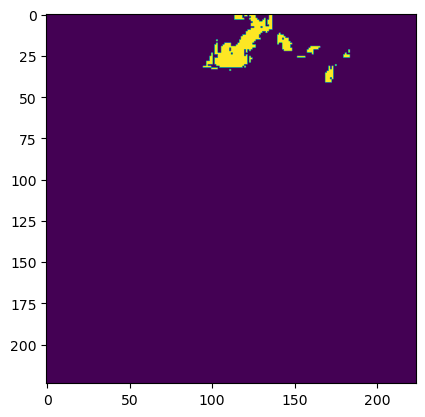

6500 квадратных метров


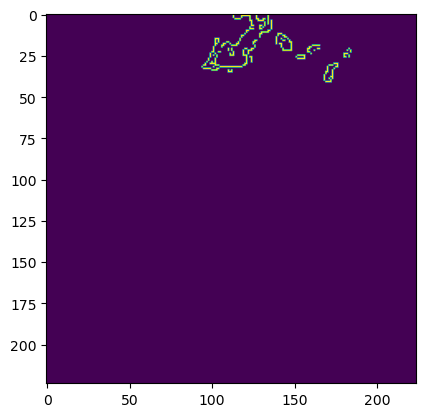

In [50]:
# Путь к тестовому изображению:
path = 'example.jpg'

# Подгружаем модель:
RFC = load_model("RFC.pickle")

# Читаем изображение
img = readimg(path)
# Сегментируем изображение, внутри функции сегменатции вызывается также функция обработки
mask = segmentation(img, RFC)
# Визулизируем маски
visualize_rs(mask)
# Считаем площадь зоны полей
print(plosh(mask), 'квадратных метров')
# Находим контуры полей:
con = contur(mask)
# Визулизируем контуры полей:
visualize_rs(con)

Функции определения маски дефицита влаги и зон аномального развития болезней по маске индекса (NDVI или NDMI) и функция определения масштаба зон болезней или дефицита влаги по маске индекса (NDVI или NDMI) также реализованы и используются в приложении, когда происходит работа с геотифами.

## Веб приложение реализовал с помощью Streamlit

Streamlit - библиотека Python с открытым кодом. Она позволяет с легкостью создавать разные красивые веб-приложения для инженеров машинного обучения. Всего за несколько минут и пару строк кода можно создать стильные приложения.

Команда для запуска веб приложения: *streamlit run streamlit.py --server.maxUploadSize=1028*

![Alt text](image-1.png)

Интерфейс имеет красивый внешний вид (выбр темы: светлая или тёмная), легко читаются слова, легко понять где, что и куда нажимать, подобрана цветовая палитра.

![Alt text](image-9.png)

Интерфейс позволяет загружать данные с одного изображения.

Интерфейс позволяет загружать данные с нескольких изображений

![Alt text](image-3.png)

Интерфейс позволяет проводить сегментацию изображений (определение полей). Если
полей нет, то выдается соответствующее предупреждение.

![Alt text](image-4.png)

![Alt text](image-5.png)

Интерфейс позволяет выделять контуры полей.

Интерфейс позволяет определять площади полей.

![Alt text](image-6.png)

### Для изображений с geotif:
### Приложение позволяет определить зоны предполагаемого аномального развития растений (болезни) с выводом значения соответствующего индикатора и определением масштаба этих зон по маске индекса ***NDMI***

### Также интерфейс позволяет определить зоны на полях, где растения испытывают дефицит влаги с выводом значения соответствующего индикатора и определением масштаба этих зон по маске индекса ***NDVI***

![Alt text](image-7.png)

![Alt text](image-8.png)

### Инструкция по работе с приложением размещена в файле Инструкция.docx

Код приложения Streamlit: 

In [ ]:
import cv2
import os
import numpy as np
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import random
import numpy as np
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import pickle
from PIL import Image
import rasterio

import streamlit as st
import api

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 20)

model = api.load_model("RFC.pickle")

st.title('Веб приложение обработки спутниковых снимков полей')

genre = st.radio(
    "Выберите режим работы с приложением:",
    ["Только с RGB зображениями", "С изображениями с geotiff"],
    captions = ["Сегментация, обнаружение контуров, подсчёт площади", "Сегментация, обнаружение контуров, подсчёт площади, поиск болезненных зон, поиск зон с низкой влажностью"])

if genre == "Только с RGB зображениями":
    st.subheader('Загрузка RGB изображений', divider='rainbow')
    uploaded_files = st.file_uploader("Выберите изображение/изображения RGB", accept_multiple_files=True, type=["png", "jpg", "jpeg"])

    for uploaded_file in uploaded_files:
        st.subheader("Имя файла: " + uploaded_file.name, divider='rainbow')
        image = Image.open(uploaded_file)
        img_array = np.array(image)
        
        if img_array.shape[0] * img_array.shape[1] > 50176:
            st.write("Изображение превышает разрешение 224 * 224, поэтому берём его его случайный патч 224 * 224, где 1 пиксель = 10 метров")
            kus = random.randint(0, min(img_array.shape[0], img_array.shape[1]) - 225)
            img_array = img_array[kus:kus + 224, kus: kus +224]
            st.image(img_array)
        else:
            st.image(img_array)
        
        
        mask = api.segmentation(img_array, model)
        st.subheader('Результат сегментации полей:', divider='rainbow')
        st.image(mask)

        if np.count_nonzero(mask) < 1:
            st.subheader('Поля не обнаружены')
        else:
            st.subheader('Результат обнаружения контуров полей:', divider='rainbow')
            con = api.contur(mask)
            st.image(con)

            st.subheader('Площадь поля: ' + str(api.plosh(mask)) + ' квадратных метров')

else:
    st.subheader('Загрузка изображений с geotiff', divider='rainbow')

    B_4 = None
    uploaded_file = st.file_uploader("Выберите B04", accept_multiple_files=False, type=["tif"])
    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        B_4 = np.array(image)

    B_8 = None
    if B_4 is not None:
        uploaded_file = st.file_uploader("Выберите B08", accept_multiple_files=False, type=["tif"])
        if uploaded_file is not None:
            image = Image.open(uploaded_file)
            B_8 = np.array(image)

    B_11 = None
    if B_8 is not None:
        uploaded_file = st.file_uploader("Выберите B11", accept_multiple_files=False, type=["tif"])
        if uploaded_file is not None:
            image = Image.open(uploaded_file)
            B_11 = np.array(image)

            if B_11.shape[0] < 10980 or B_11.shape[1] < 10980:
                st.write("У индекса B_11 другое разрешение, сделаем ресайз для приведения к 10 метрам")
                B_11 = cv2.resize(np.array(B_11), (10980, 10980), interpolation = cv2.INTER_AREA)

    RGB = None
    if B_11 is not None:
        uploaded_file = st.file_uploader("Выберите RGB изображение", accept_multiple_files=False, type=["png"])
        if uploaded_file is not None:
            image = Image.open(uploaded_file)
            RGB = np.array(image)

    if RGB is not None:
        img_array = RGB
        if RGB.shape[0] * RGB.shape[1] > 50176:
            st.write("Изображение превышает разрешение 224 * 224, поэтому берём его его случайный патч 224 * 224, где 1 пиксель = 10 метров")
            kus = random.randint(0, min(img_array.shape[0], img_array.shape[1]) - 225)
            img_array = img_array[kus:kus + 224, kus: kus +224]
            B_4 = B_4[kus:kus + 224, kus: kus +224]
            B_8 = B_8[kus:kus + 224, kus: kus +224]
            B_11 = B_11[kus:kus + 224, kus: kus +224]
            st.write("RGB изображение:")
            st.image(img_array)
            st.write("NDMI изображение:")
            NDMI = (B_8 - B_11) / (B_8 + B_11)
            NDMI = (NDMI-np.min(NDMI))/(np.max(NDMI)-np.min(NDMI)) * 255
            st.image(NDMI.astype(np.uint8))
            st.write("NDVI изображение:")
            NDVI = (B_8 - B_4) / (B_8 + B_4)
            NDVI = (NDVI-np.min(NDVI))/(np.max(NDVI)-np.min(NDVI)) * 255
            st.image(NDVI.astype(np.uint8))

            mask = api.segmentation(img_array, model)
            st.subheader('Результат сегментации полей:', divider='rainbow')
            st.image(mask)

            if np.count_nonzero(mask) < 1:
                st.subheader('Поля не обнаружены')
            else:
                st.subheader('Результат обнаружения контуров полей:', divider='rainbow')
                con = api.contur(mask)
                st.image(con)

                st.subheader('Площадь поля: ' + str(api.plosh(mask)) + ' квадратных метров')

            st.subheader('Результат определения зон с дефицитом влаги, где NDVI < 0.35:', divider='rainbow')
            mask_def, indicator = api.defic(NDVI)
            st.image(mask_def)
            st.subheader('Площадь с дефицитом влаги: ' + str(api.plosh(mask_def)) + ' квадратных метров. Индикатор ' + str(indicator))

            st.subheader('Результат определения зон с предполагаемым аномальным развитием растений (болезни), где NDMI < 0.35:', divider='rainbow')
            mask_def, indicator = api.defic(NDMI)
            st.image(mask_def)
            st.subheader('Площадь зон с предполагаемым аномальным развитием растений (болезни): ' + str(api.plosh(mask_def)) + ' квадратных метров. Индикатор ' + str(indicator))

        else:
            st.write("RGB изображение:")
            st.image(img_array)
            st.write("NDMI изображение:")
            NDMI = (B_8 - B_11) / (B_8 + B_11)
            NDMI = (NDMI-np.min(NDMI))/(np.max(NDMI)-np.min(NDMI)) * 255
            st.image(NDMI.astype(np.uint8))
            st.write("NDVI изображение:")
            NDVI = (B_8 - B_4) / (B_8 + B_4)
            NDVI = (NDVI-np.min(NDVI))/(np.max(NDVI)-np.min(NDVI)) * 255
            st.image(NDVI.astype(np.uint8))

            mask = api.segmentation(img_array, model)
            st.subheader('Результат сегментации полей:', divider='rainbow')
            st.image(NDVI < 255 * 0.35)

            if np.count_nonzero(mask) < 1:
                st.subheader('Поля не обнаружены')
            else:
                st.subheader('Результат обнаружения контуров полей:', divider='rainbow')
                con = api.contur(mask)
                st.image(con)

                st.subheader('Площадь поля: ' + str(api.plosh(mask)) + ' квадратных метров')
    
            st.subheader('Результат определения зон с дефицитом влаги, где NDVI < 0.35:', divider='rainbow')
            mask_def, indicator = api.defic(NDVI)
            st.image(mask_def)
            st.subheader('Площадь с дефицитом влаги: ' + str(api.plosh(mask_def)) + ' квадратных метров. Индикатор ' + str(indicator))

            st.subheader('Результат определения зон с предполагаемым аномальным развитием растений (болезни), где NDMI < 0.35:', divider='rainbow')
            mask_def, indicator = api.defic(NDMI)
            st.image(mask_def)
            st.subheader('Площадь зон с предполагаемым аномальным развитием растений (болезни): ' + str(api.plosh(mask_def)) + ' квадратных метров. Индикатор ' + str(indicator))



Само приложение в файле streamlit.py

Видно, что приложение явно импортирует API в файле api и использует его функции:

![Alt text](image-10.png)

# Выводы:

Разработка API

1. Разработано API
2. Разработана и реализована функция загрузки изображения/изображений.
3. Разработана и реализована функция обработки изображения.
4. Разработана и реализована функция для сегментации изображений (поля).
5. Разработана и реализована функция визуализации результатов сегментации.
6. Разработана и реализована функция определения площади полей.
8. Разработана и реализована функция формирования зон предполагаемого аномального
развития растений (болезни) с выводом значения соответствующего индикатора и
определением масштаба этих зон.

Разработка графического интерфейса пользователя (приложение) 

1. Интерфейс разработан в виде приложения.
2. Интерфейс имеет красивый внешний вид, легко читаются слова, легко понять где, что и куда
нажимать, подобрана цветовая палитра.
3. Интерфейс использует методы и функции из API предыдущего модуля.
4. Интерфейс позволяет загружать данные с одного изображения.
5. Интерфейс позволяет загружать данные с нескольких изображений.
6. Интерфейс позволяет проводить сегментацию изображений (определение полей). Если
полей нет, то выдается соответствующее предупреждение.
7. Интерфейс позволяет выделять контуры полей.
8. Интерфейс позволяет определять площади полей.
10. Интерфейс позволяет определить зоны предполагаемого аномального развития растений
(болезни) с выводом значения соответствующего индикатора и определением масштаба
этих зон.
11. Интерфейс позволяет определить зоны на полях, где растения испытывают дефицит влаги с
выводом значения соответствующего индикатора и определением масштаба этих зон. 

Сделана инструкция по работе с приложением

# Модуль 5

В рамках данного модуля нам предстоит оценить точность построенной модели на
секретной выборке, оценить результат. Также необходимо будет подготовить продукт для
передачи заказчику – оформить инструкцию для пользователя, презентацию и сделать доклад. 


Импортим библиотеки:

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tqdm
from statistics import mean

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 20)

Объявляем необходимые функции для подгрузки датасета, сегментации и подсчёта метрик:

In [2]:
def readimg(img_path):
    img = cv2.imread(img_path, 0)
    return img

def oredobr_img(img):
    img.flatten()
    vec = img.reshape((-1,1))
    return vec

def segmentation(img_path, model):
    img = readimg(img_path)
    shape = img.shape
    vec = oredobr_img(img)
    res = model.predict(vec)
    mask = res.reshape(shape)
    return mask

def IOU(or_mask, mask):
    overlap = or_mask * mask 
    union = or_mask + mask
    IOU = overlap.sum()/float(union.sum())
    return IOU

def DICE(or_mask, mask):
    overlap = or_mask * mask 
    union = or_mask + mask
    DICE = 2 * overlap.sum() / union.sum()
    return DICE

Обрабатываем тестовый датасет:

0it [00:00, ?it/s]

image_image_01008_20210720_const_0001.jpg


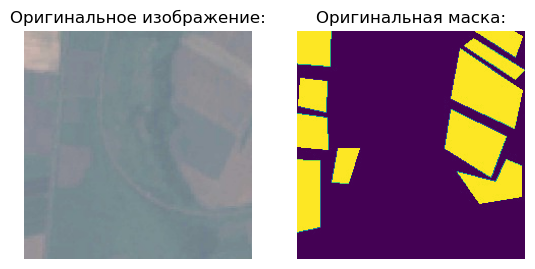

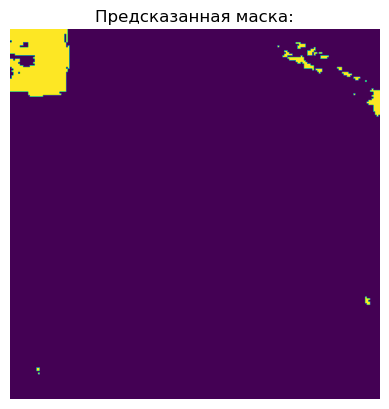

1it [00:00,  3.41it/s]

IOU 0.08192281846429535
DICE 0.1638456369285907
image_image_01008_20210720_const_0002.jpg


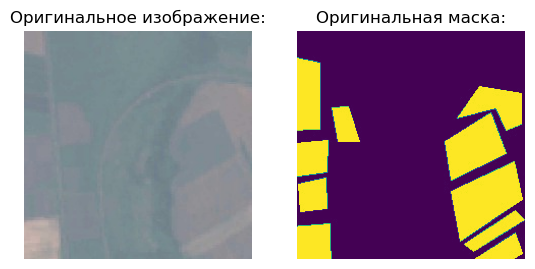

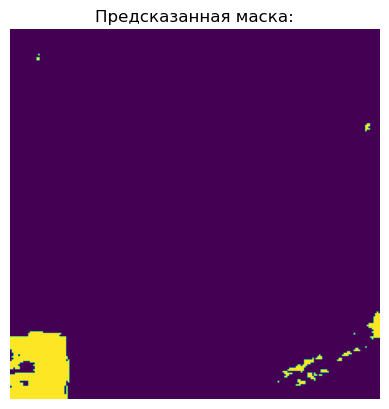

2it [00:00,  3.47it/s]

IOU 0.08192281846429535
DICE 0.1638456369285907
image_image_01008_20210720_const_0003.jpg


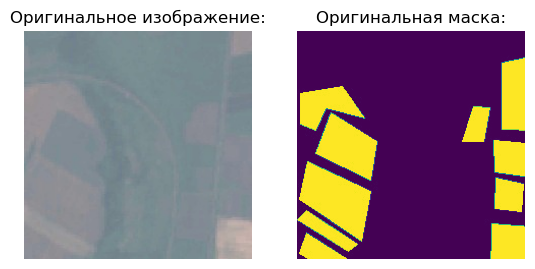

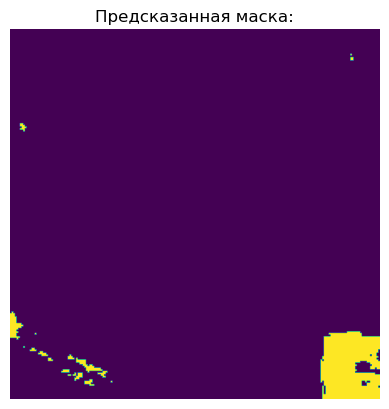

3it [00:00,  3.56it/s]

IOU 0.08117869909067338
DICE 0.16235739818134676
image_image_01008_20210720_const_0004.jpg


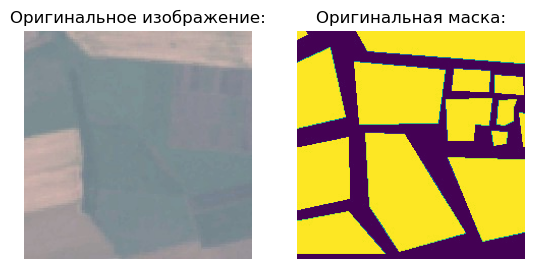

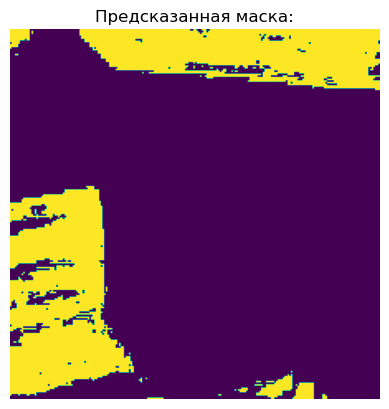

4it [00:01,  3.44it/s]

IOU 0.15856058778026583
DICE 0.31712117556053165
image_image_01008_20210720_const_0005.jpg


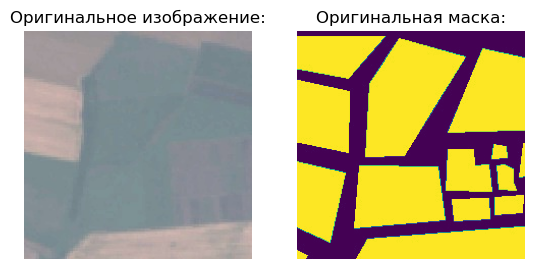

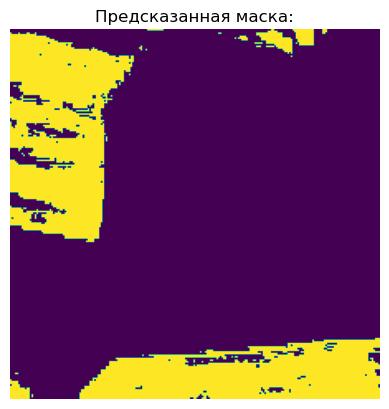

5it [00:01,  3.53it/s]

IOU 0.15856058778026583
DICE 0.31712117556053165
image_image_01008_20210720_const_0006.jpg


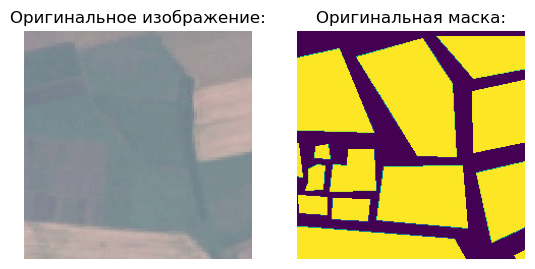

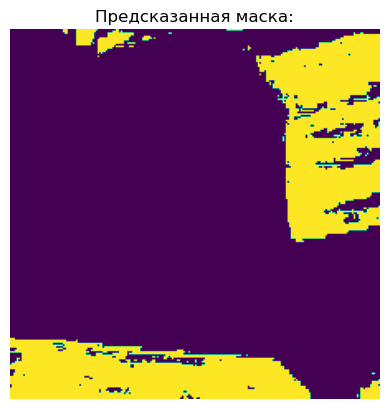

6it [00:01,  3.19it/s]

IOU 0.15801617188459288
DICE 0.31603234376918576
image_image_01008_20210720_const_0007.jpg


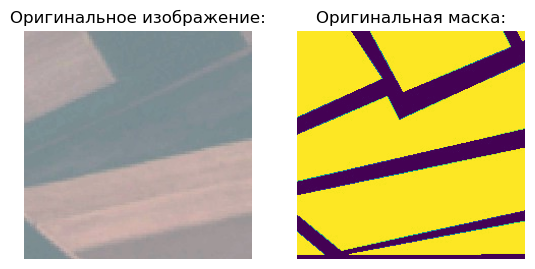

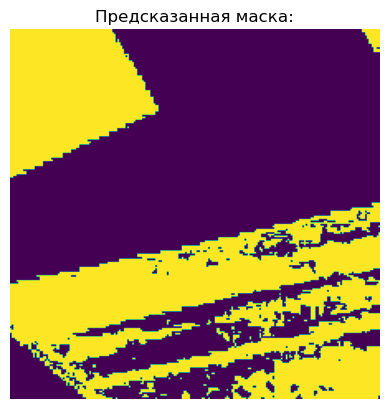

7it [00:02,  3.28it/s]

IOU 0.3284355868554098
DICE 0.6568711737108196
image_image_01008_20210720_const_0008.jpg


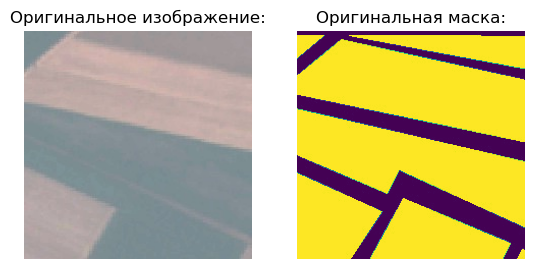

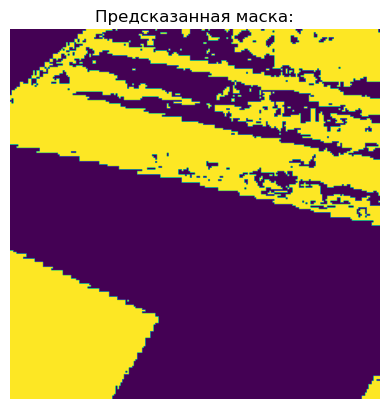

8it [00:02,  3.33it/s]

IOU 0.3284355868554098
DICE 0.6568711737108196
image_image_01008_20210720_const_0009.jpg


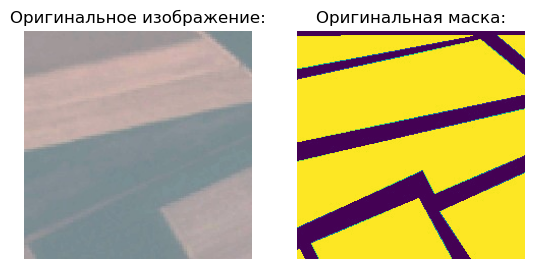

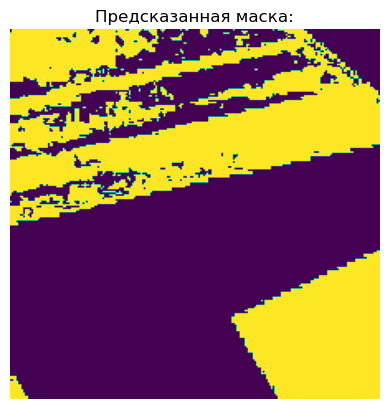

9it [00:02,  3.44it/s]

IOU 0.32941645424443416
DICE 0.6588329084888683
image_image_01008_20210720_const_0010.jpg


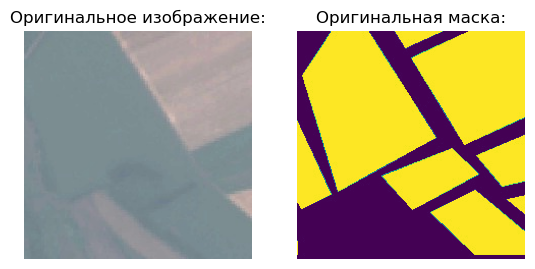

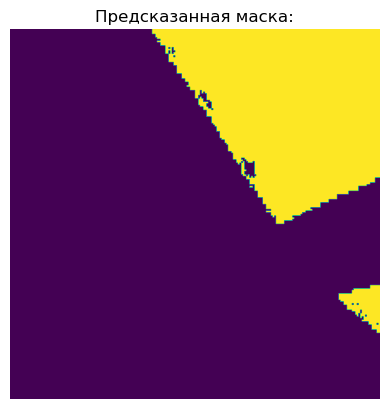

11it [00:03,  4.27it/s]

IOU 0.20911847941521416
DICE 0.41823695883042833


660it [01:08,  9.59it/s]

-----------------------------------------------
Итоговая точность на тестовом датасете:
IOU:  0.16508587306199296
DICE:  0.3301717461239859


In [4]:
# Указываем пути к тестовым данным:
path_images = 'valid_new/images/'
path_labels = 'valid_new/labels/'
# Указываем путь к папке, куда буду сохранять полученные с помощью нашей модели маски:
path_for_save_masks = 'valid_new/my_masks/'

# Читаем названия изображений и размеченных масок:
names_images = os.listdir(path_images)
names_labels = os.listdir(path_labels)

# Загружаем нашу лучшую модель:
filename = "RFC.pickle"
RFC = pickle.load(open(filename, "rb"))

# Объявляем листы для подсчёта средних значений метрик:
IOUs = []
DICEs = []

rows = 1
columns = 3

# Обрабатываем в цикле изображения, визуализируем сегментацию для первых 10 изображений:
for i, name_img in tqdm.tqdm(enumerate(names_images)):

    # Визуализация для первых 10:
    if i < 10:
        fig = plt.figure(figsize=(10, 7))
        print(name_img)

    # Читаем оригинал изображения
    img_or = cv2.imread(path_images + name_img)
    # Переводим в RGB для визуализации с помощью PIL
    img_or = cv2.cvtColor(img_or, cv2.COLOR_BGR2RGB)
    # Читаем это же изображение и сразу же предобрабатываем его для входа в модель:
    img = readimg(path_images + name_img)

    # Визуализация для первых 10:
    if i < 10:
        fig.add_subplot(rows, columns, 1)
        plt.imshow(img_or)
        plt.axis('off')
        plt.title("Оригинальное изображение:")

    # Читаем оригинальную маску
    or_mask = readimg(path_labels + names_labels[i])
    # Визуализация для первых 10:
    if i < 10:
        fig.add_subplot(rows, columns, 2)
        plt.imshow(or_mask)
        plt.axis('off')
        plt.title("Оригинальная маска:")
        plt.show()

    # Получаем сегментирующую маску с помощью модели:
    predict_mask = segmentation(path_images + name_img, RFC)

    # Сохраняем сегментирующую маску, полученную с помощью модели:
    cv2.imwrite(path_for_save_masks + 'my_' + names_labels[i], predict_mask)

    # Считаем метрики IOU и DICE:
    IOU_tec = IOU(or_mask, predict_mask)
    DICE_tec = DICE(or_mask, predict_mask)

    # Добавляем метрики в листы для подсчёта средних значений:
    IOUs.append(IOU_tec)
    DICEs.append(DICE_tec)

    # Визуализация для первых 10:
    if i < 10:
        fig.add_subplot(rows, columns, 3)
        plt.imshow(predict_mask)
        plt.axis('off')
        plt.title("Предсказанная маска:")
        plt.show()

        print('IOU', IOU_tec)
        print('DICE', DICE_tec)

print('-----------------------------------------------')
print('Итоговая точность на тестовом датасете:')
print('IOU: ', mean(IOUs))
print('DICE: ',mean(DICEs))

Точность модели IOU 0.16508587306199296 и DICE 0.3301717461239859 невелики. Но для классической модели, которую мы обучили  под задачу сегментации довольно неплохие. Для получения лучших результатов необходимо обучать свёрточную модель или трансформер. Но в рамках соревнований на это не хватило бы времени.

#### Инструкция работы с приложением приведена в файле: ***Инструкция.docx***

Инструкция содержит описание полного функционала работы системы.

Инструкция оформлена профессионально (в соответствии с профессиональными стандартами). В соответствии с РД 50-34.698-90 - в части структуры и содержания документов, и в соответствии с ГОСТ 34.201-89 - в части наименования и обозначения документов.

#### Подготовлена презентация в файле: ***C5[6]_MA_БольшаковТЕ.pptx***

1. Презентация, охватывает все результаты выполнения конкурсного задания.

2. В презентации указано ёмкое описание результатов работы с обоснованием выбора того или
иного решения.

3. В презентации имеются скриншоты работы программы и выводимых результатов.

4. Презентация включает клиентоориентированную часть.

5. В презентации присутствуют перспективы улучшения модели и дальнейшего использования
результатов в промышленности

### Подготовлен устный доклад

# Выводы:

1. Проведена ценка точности разработанной модели на «секретной» выборке

2. Выполнен расчет индексов IoU и Dice для набора данных. Сделан вывод о точности.

3. Разработана инструкция для пользователя по работе с разработанной системой (файл с
названием Инструкция в формате docx).

4. Инструкция содержит описание полного функционала работы системы.

5. Инструкция оформлена профессионально (в соответствии с профессиональными стандартами).

Подготовка презентации

6. Презентация, охватывает все результаты выполнения конкурсного задания.

7. В презентации указано ёмкое описание результатов работы с обоснованием выбора того или
иного решения.

8. В презентации имеются скриншоты работы программы и выводимых результатов.

9. Презентация включает клиентоориентированную часть.

10. В презентации присутствуют перспективы улучшения модели и дальнейшего использования
результатов в промышленности.